# Lab3: Data Preparation and Tree: Imputation, Variable Selection, PCA and Decision Tree


This lab material is largely self-contained. We assume that every student has already taken STAT7008 or knows some basic operations of Python. Noet that you may use Anaconda to run this .ipynb file. For the installation of Anaconda, please see https://conda.io/docs/user-guide/install/index.html.

### Purpose

In Lab 3, you will learn how to:

a. do imputation. 

b. do variable selection by Least Angle Regression (LAR).

c. do Principal Component Analysis (PCA).

d. build a decision tree. 

### Useful libraries for this Lab

a. pandas, for data frame.

b. numpy, for data array. 

c. sklearn, for modelling.

d. os, for the working directory. 

In [1]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import tree

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import os

wd = os.getcwd() # Set your working directory. 
print wd

/home/renjielu/PycharmProjects/DM8017/DM_Lab3


We load the data which is stored in an xlsx file called Pva97nk. You can download it from Moodle. Please make sure that the pacakge called xlrd (can extract data from Microsoft Excel spreadsheet files) has already been installed in your computer.

In [2]:
df = pd.read_excel(wd+'/Pva97nk.xlsx')

print df.head()

   TargetB      ID  TargetD  GiftCnt36  GiftCntAll  GiftCntCard36  \
0        0   14974      NaN          2           4              1   
1        0    6294      NaN          1           8              0   
2        1   46110      4.0          6          41              3   
3        1  185937     10.0          3          12              3   
4        0   29637      NaN          1           1              1   

   GiftCntCardAll  GiftAvgLast  GiftAvg36  GiftAvgAll     ...       \
0               3         17.0      13.50        9.25     ...        
1               3         20.0      20.00       15.88     ...        
2              20          6.0       5.17        3.73     ...        
3               8         10.0       8.67        8.50     ...        
4               1         20.0      20.00       20.00     ...        

   PromCntCardAll  StatusCat96NK  StatusCatStarAll  DemCluster  DemAge  \
0              13              A                 0           0     NaN   
1              2

From a part of records above, we see that there exist missing values in some variables, like DemAge. Note that the missing values in the data frame are stored as NaN. We take DemAge for example to show imputation methods. Here, we simply use the mean to replace these missing values. 

In [3]:
print df['DemAge'].isnull().values.any() 
print 'So, missing values exist.' # check the missing values. FALSE: no missing value.

imputer = preprocessing.Imputer()
transform_data = imputer.fit_transform(df['DemAge'].values.reshape((-1,1)))

df['DemAge'] = pd.Series(transform_data.ravel())

print df['DemAge'].isnull().values.any() 
print 'So, no missing value exists.' # check the missing values. FALSE: no missing value.

True
So, missing values exist.
False
So, no missing value exists.


Next, we consider to use TargetD as the response, and set DemAge, DemMedIncome, and GiftAvgLast as predictors. We only consider the non-missing part of TargetD. We use the mean to replace the missing values in the predictors. Note that we do a log transform of TargetD to smooth it. See SAS materials for more details. 

In [4]:

TargetD = df['TargetD'][df['TargetD'].isnull()==False].values
DemAge = df['DemAge'][df['TargetD'].isnull()==False]
DemMedIncome = df['DemMedIncome'][df['TargetD'].isnull()==False]
GiftAvgLast = df['GiftAvgLast'][df['TargetD'].isnull()==False]

DemAge = imputer.fit_transform(DemAge.values.reshape((-1,1)))
DemMedIncome = imputer.fit_transform(DemMedIncome.values.reshape((-1,1)))
GiftAvgLast = imputer.fit_transform(GiftAvgLast.values.reshape((-1,1)))

df_case = pd.DataFrame(np.concatenate((np.log(TargetD.reshape((-1,1))), 
                                       DemAge, 
                                       DemMedIncome, 
                                       GiftAvgLast), axis = 1),
                       columns=['y', 'x1', 'x2', 'x3'])

print df_case.head()

          y         x1       x2    x3
0  1.386294  59.150845  38750.0   6.0
1  2.302585  59.150845  38942.0  10.0
2  2.397895  47.000000  92514.0  11.0
3  3.688879  59.150845      0.0  35.0
4  1.791759  59.150845      0.0   6.0


Here, we provide the code to implement LAR which finds the predictor most correlated with the response at each step. From the result below, we conclude that LAR will select DemAge and GiftAvgLast if only two predictors are required to be kept. 

In [5]:

case_matrix = df_case.values

reg = linear_model.Lars(n_nonzero_coefs=2)
reg.fit(case_matrix[:,1:], case_matrix[:,0])

print reg.active_ # show the active variables.
print reg.coef_ # show the coefficients of active vairbales. 


[2, 0]
[-0.00081817  0.          0.02405108]


After LAR, we go to do PCA over the last three columns in case_matrix. For more details about PCA, you may read the supplement in Moodle.

[  9.99999553e-01   2.33656426e-07]


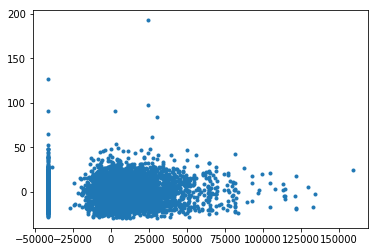

In [6]:

pca = PCA(n_components=2)
pca.fit(case_matrix[:,1:])

pca_ = pca.fit_transform(case_matrix[:,1:])

print pca.explained_variance_ratio_

plt.plot(pca_[:,0],pca_[:,1],'.')

plt.show()

Lastly, we build a simple decision tree (not a regression tree). We cut the target variable into two categories. Note that if you want to visualize the tree built by Sklearn, please install Graphviz.

[ 0.  0.  1.]


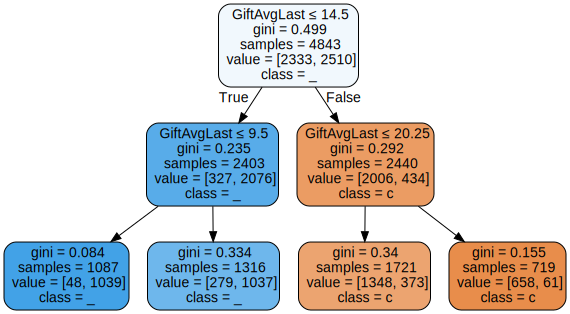

In [7]:

df_case['c_y'] = pd.cut(df_case['y'],2,labels=[1,0])

case_matrix = df_case.iloc[:,1:]


clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(case_matrix.iloc[:,:-1], case_matrix.iloc[:,-1])

print clf.feature_importances_ # GiftAvgLast is the most important. 


dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=['DemAge','DemMedIncome','GiftAvgLast'],  
                         class_names='c_log_TargetD',  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  

graph
